## CLIM 680 Project: AMV Index Analysis
### Douglas Nedza

Calculate and plot the composite maps for a chosen index.

The data I am using for this analysis is from a CMIP5 pre-industrial run.  Due to the independence of this dataset with observations, a climate index will be calculated from the chosen dataset.

## Import necessary Python packages and Load the Data

In [1]:
import numpy as np;
import xarray as xr;
import matplotlib.pyplot as plt;

import cartopy.crs as ccrs;
import cartopy.mpl.ticker as cticker;
from cartopy.util import add_cyclic_point;

from scipy.stats import ttest_ind;

from scipy.stats import pearsonr

from scipy.stats import linregress as lr;

import warnings

from dask.diagnostics import ProgressBar


In [2]:
warnings.filterwarnings( action = 'ignore' );

In [3]:
## Read dataset into notebook.  
##Calculate the annual means simultaneously to remove the dominant effect of the seasonal cycle. This also decreases the amount of data in memory.  
sst_path = '/shared/cmip5/data/piControl/ocean/mon/Omon/tos/NASA-GISS.GISS-E2-H/r1i1p1/';
atmos_path = '/shared/cmip5/data/piControl/atmos/mon/Amon/';
ts_path = atmos_path + '/ts/NASA-GISS.GISS-E2-H/r1i1p1/';
pr_path = atmos_path + '/pr/NASA-GISS.GISS-E2-H/r1i1p1/';
sst_file = 'tos_Omon_GISS-E2-H_piControl_r1i1p1_251001-255912.nc';
ts_file = 'ts_Amon_GISS-E2-H_piControl_r1i1p1_251001-255912.nc';
pr_file =  'pr_Amon_GISS-E2-H_piControl_r1i1p1_251001-255912.nc';
sst_ds = xr.open_mfdataset( ( sst_path + sst_file ), concat_dim = 'time' ).groupby( 'time.year' ).mean( dim = 'time' );
ts_ds = xr.open_mfdataset( ( ts_path + ts_file ), concat_dim = 'time' ).groupby( 'time.year' ).mean( dim = 'time' );
pr_ds = xr.open_mfdataset( ( pr_path + pr_file ), concat_dim = 'time' ).groupby( 'time.year' ).mean( dim = 'time' );
##Convert precipitation from mm/s to mm/day
pr_ds['pr'] = pr_ds['pr'] * 8.64 * ( 10 ** 4 );
sst_ds
## Note that there is no units attribute for this file.

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 90, lon: 144, year: 50)
Coordinates:
  * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * year      (year) int64 2510 2511 2512 2513 2514 ... 2555 2556 2557 2558 2559
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 dask.array<chunksize=(1, 90, 2), meta=np.ndarray>
    lon_bnds  (year, lon, bnds) float64 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    tos       (year, lat, lon) float32 dask.array<chunksize=(1, 90, 144), meta=np.ndarray>

In [4]:
##Shift the longitude of the ocean dataset to be consistent with the atmospheric datasets
new_rlon = ( sst_ds['lon'] + 360 ) % 360;
sst_ds = sst_ds.assign_coords( rlon = new_rlon );
sst_ds = sst_ds.sortby( sst_ds['lon'] );
sst_ds

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 90, lon: 144, year: 50)
Coordinates:
  * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * year      (year) int64 2510 2511 2512 2513 2514 ... 2555 2556 2557 2558 2559
    rlon      (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 dask.array<chunksize=(1, 90, 2), meta=np.ndarray>
    lon_bnds  (year, lon, bnds) float64 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    tos       (year, lat, lon) float32 dask.array<chunksize=(1, 90, 144), meta=np.ndarray>

## Calculate an Index of the Atlantic Multidecadal Oscillation, the averaged SST over the North Atlantic ocean.

In [5]:
sst_na = sst_ds.sel( lat = slice( 0, 60 ),
                         lon = slice( 360-75, 360 ) );
sst_na

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 30, lon: 30, year: 50)
Coordinates:
  * lat       (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 51.0 53.0 55.0 57.0 59.0
  * lon       (lon) float64 286.2 288.8 291.2 293.8 ... 351.2 353.8 356.2 358.8
  * year      (year) int64 2510 2511 2512 2513 2514 ... 2555 2556 2557 2558 2559
    rlon      (lon) float64 286.2 288.8 291.2 293.8 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 dask.array<chunksize=(1, 30, 2), meta=np.ndarray>
    lon_bnds  (year, lon, bnds) float64 dask.array<chunksize=(1, 30, 2), meta=np.ndarray>
    tos       (year, lat, lon) float32 dask.array<chunksize=(1, 30, 30), meta=np.ndarray>

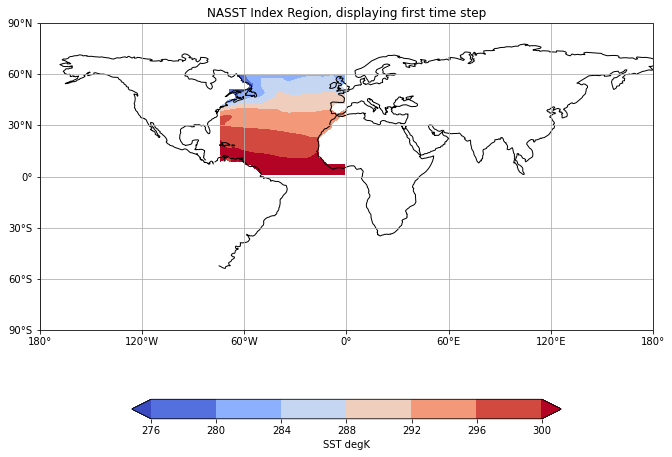

In [6]:
##Make the figure larger
fig = plt.figure( figsize = ( 11, 8.5 ) );

#Set the axes using the specified map projection
ax = plt.axes( projection = ccrs.PlateCarree() );

#Make a filled contour plot
cs = ax.contourf( sst_na['lon'],
                 sst_na['lat'],
                 sst_na['tos'][0,:,:,],
                 transform = ccrs.PlateCarree(),
                 cmap = 'coolwarm', extend = 'both' );

#Add coastlines
ax.coastlines();

#Add gridlines
ax.gridlines();

##Define the xticks for longitude
ax.set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
lon_formatter = cticker.LongitudeFormatter();
ax.xaxis.set_major_formatter( lon_formatter );

##Define the yticks for latitude
ax.set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
lat_formatter = cticker.LatitudeFormatter();
ax.yaxis.set_major_formatter( lat_formatter );

#Add colorbar
cbar = plt.colorbar( cs, shrink = 0.7,
                    orientation = 'horizontal',
                    label = 'SST degK' );

#Add title.  Note that using .groupby().mean() removes the attributes that describe the dataset
plt.title( 'NASST Index Region, displaying first time step' );

<xarray.DataArray 'tos' (year: 50)>
dask.array<mean_agg-aggregate, shape=(50,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 2510 2511 2512 2513 2514 ... 2555 2556 2557 2558 2559


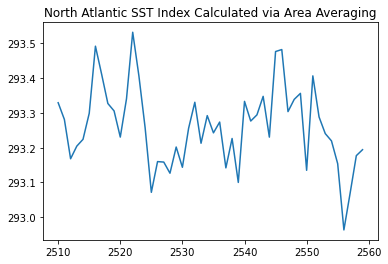

In [7]:
nasst_ind = sst_na['tos'].mean( dim = ( 'lat', 'lon' ) );
print( nasst_ind );
plt.plot( nasst_ind['year'], nasst_ind );
plt.title( 'North Atlantic SST Index Calculated via Area Averaging' );

### Center the Time Series

Text(0, 0.5, 'NASST Anomaly degC')

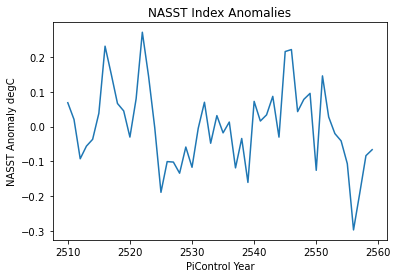

In [8]:
nasst_mean = nasst_ind.mean();
nasst_ind = nasst_ind - nasst_mean;
plt.plot( nasst_ind['year'], nasst_ind );
plt.title( 'NASST Index Anomalies' );
plt.xlabel( 'PiControl Year' );
plt.ylabel( 'NASST Anomaly degC' )

## Determine the Composite maps of Precipitation and Surface Temperature relative to the calculated AMO index

Based on a visual inspection of the variability of the Area Averaged NASST Index, thresholds are chosen at +- 0.2 degrees celsius

In [9]:
##By omitting return values for the where() function, Nans will be returned where the condition is not met
pos_nasst = nasst_ind.where( nasst_ind >= 0.1 );
neg_nasst = nasst_ind.where( nasst_ind <= -0.1 );
neutral = nasst_ind.where( np.logical_and( nasst_ind > -0.1, nasst_ind < 0.1 ) );
##The 'and' command will attempt to find a single true/false value

In [10]:
print( 'Positive NASST: ', pos_nasst.count( dim = 'year' ).values );
print( 'Negative NASST: ', neg_nasst.count( dim = 'year' ).values );
print( 'Neutral: ', neutral.count( dim = 'year' ).values );

counts = [pos_nasst.count( dim = 'year' ).values, 
         neg_nasst.count( dim = 'year' ).values, 
         neutral.count( dim = 'year' ).values ];
print( counts );

Positive NASST:  7
Negative NASST:  11
Neutral:  32
[array(7), array(11), array(32)]


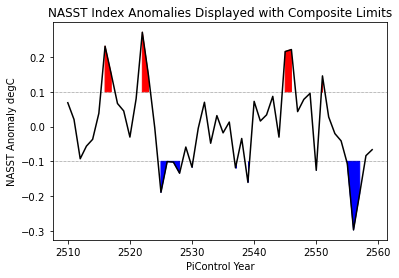

In [11]:
plt.plot( nasst_ind['year'], nasst_ind, 'k' );
plt.fill_between( nasst_ind['year'], 0.1, pos_nasst, color = 'red' );
plt.fill_between( nasst_ind['year'], neg_nasst, -0.1, color = 'blue' );
plt.axhline( 0.1, color = 'black', linewidth = 0.5, linestyle = 'dotted' );
plt.axhline( -0.1, color = 'black', linewidth = 0.5, linestyle = 'dotted' );
plt.title( 'NASST Index Anomalies Displayed with Composite Limits' );
plt.ylabel( 'NASST Anomaly degC' );
plt.xlabel( 'PiControl Year' );

## Sea Surface Temperature

In [12]:
sst_climo = sst_ds.mean( dim = 'year' );
sst_anoms = sst_ds - sst_climo;
sst_anoms

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 90, lon: 144, year: 50)
Coordinates:
  * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * year      (year) int64 2510 2511 2512 2513 2514 ... 2555 2556 2557 2558 2559
    rlon      (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 dask.array<chunksize=(1, 90, 2), meta=np.ndarray>
    lon_bnds  (year, lon, bnds) float64 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    tos       (year, lat, lon) float32 dask.array<chunksize=(1, 90, 144), meta=np.ndarray>

In [13]:
pos_sst = sst_anoms.sel( year = pos_nasst.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );
neg_sst = sst_anoms.sel( year = neg_nasst.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );
neutral_sst = sst_anoms.sel( year = neutral.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );

comp_sst = [pos_sst, neg_sst, neutral_sst];
comp_sst                      

[<xarray.Dataset>
 Dimensions:   (bnds: 2, lat: 90, lon: 144)
 Coordinates:
   * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
     rlon      (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
 Dimensions without coordinates: bnds
 Data variables:
     lat_bnds  (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
     lon_bnds  (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
     tos       (lat, lon) float32 dask.array<chunksize=(90, 144), meta=np.ndarray>,
 <xarray.Dataset>
 Dimensions:   (bnds: 2, lat: 90, lon: 144)
 Coordinates:
   * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
     rlon      (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
 Dimensions without coordinates: bnds
 Data variables:
     lat_bnds  (lat, bnds) 

Text(0.5, 0.98, 'Composite SST Anomalies during NASST Variations')

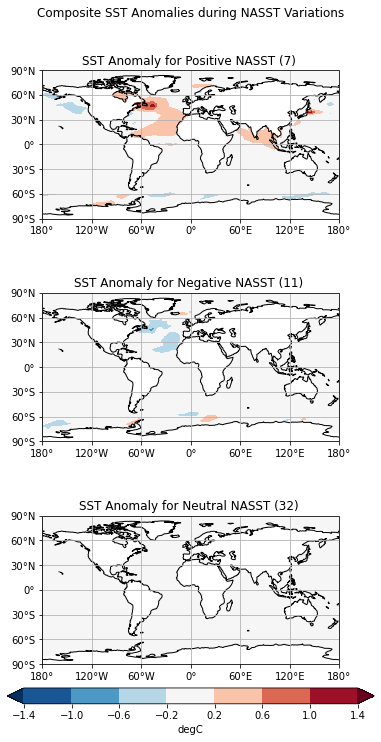

In [14]:
labels = ['Positive NASST', 'Negative NASST', 'Neutral NASST'];
clevs = np.arange( -1.4, 1.8, 0.4 );

## Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots( nrows = 3, ncols = 1,
                       subplot_kw = {'projection': ccrs.PlateCarree() },
                       figsize = (8.5, 11) );
## axs is a 2 dimensional array of 'GeoAxes'.
##We will flatten this into a 1D array
axs = axs.flatten();

##Loop over each of the conditions and plot
for i, nasst in enumerate( comp_sst ):
    ##Select the comp
    data = comp_sst[i]['tos'];
    ##Add the cyclic point
    data,lons = add_cyclic_point( data, coord = comp_sst[i]['lon'] );
    ##Create the contour plot
    cs = axs[i].contourf( lons, comp_sst[i]['lat'], data, clevs,
                        transform = ccrs.PlateCarree(),
                        cmap = 'RdBu_r', extend = 'both' );
    ##Longitude labels 
    axs[i].set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
    lon_formatter = cticker.LongitudeFormatter();
    axs[i].xaxis.set_major_formatter( lon_formatter );
    ##Latitude labels
    axs[i].set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
    lat_formatter = cticker.LatitudeFormatter();
    axs[i].yaxis.set_major_formatter( lat_formatter );
    ##Title each subplot with the name of the composite
    axs[i].set_title( 'SST Anomaly for ' + labels[i] + ' (' + str(counts[i]) + ') ' );
    ##Draw the coastlines for each subplot
    axs[i].coastlines();
    axs[i].gridlines();
    
    
##Adjust the location of the subplots to make room for colorbar
fig.subplots_adjust( bottom = 0.15, top = 0.9, left = 0.05, right = 0.95,
                   wspace = 0.1, hspace = 0.5 );
##Add a colorbar axis
cbar_ax = fig.add_axes( [0.2, 0.1, 0.6, 0.02] );
cbar = fig.colorbar( cs, cax = cbar_ax, orientation = 'horizontal', label = 'degC' );

plt.suptitle( 'Composite SST Anomalies during NASST Variations')

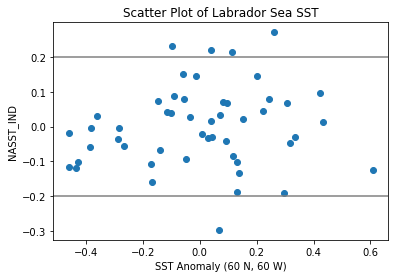

In [15]:
##Select out the point for the high composite value
pt_sst = sst_anoms.sel( lat = 60, lon = 360-60, method = 'nearest' );
plt.scatter( pt_sst['tos'], nasst_ind );
plt.xlabel( 'SST Anomaly (60 N, 60 W)' );
plt.ylabel( 'NASST_IND' );

plt.axhline( 0.2, color = 'gray' );
plt.axhline( -0.2, color = 'gray' );
plt.title( 'Scatter Plot of Labrador Sea SST' );

## Surface Temperature

In [16]:
##Create a climatology to find the precipitation anomalies
ts_climo = ts_ds.mean( dim = 'year' );
ts_anoms = ts_ds - ts_climo;
ts_anoms

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 90, lon: 144, year: 50)
Coordinates:
  * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * year      (year) int64 2510 2511 2512 2513 2514 ... 2555 2556 2557 2558 2559
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 dask.array<chunksize=(1, 90, 2), meta=np.ndarray>
    lon_bnds  (year, lon, bnds) float64 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    ts        (year, lat, lon) float32 dask.array<chunksize=(1, 90, 144), meta=np.ndarray>

In [17]:
pos_ts = ts_anoms.sel( year = pos_nasst.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );
neg_ts = ts_anoms.sel( year = neg_nasst.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );
neutral_ts = ts_anoms.sel( year = neutral.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );

comp_ts = [pos_ts, neg_ts, neutral_ts];
comp_ts                      

[<xarray.Dataset>
 Dimensions:   (bnds: 2, lat: 90, lon: 144)
 Coordinates:
   * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
 Dimensions without coordinates: bnds
 Data variables:
     lat_bnds  (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
     lon_bnds  (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
     ts        (lat, lon) float32 dask.array<chunksize=(90, 144), meta=np.ndarray>,
 <xarray.Dataset>
 Dimensions:   (bnds: 2, lat: 90, lon: 144)
 Coordinates:
   * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
 Dimensions without coordinates: bnds
 Data variables:
     lat_bnds  (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
     lon_bnds  (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
     ts        (

Text(0.5, 0.98, 'Composite Surface Temperature Anomalies during NASST Variations')

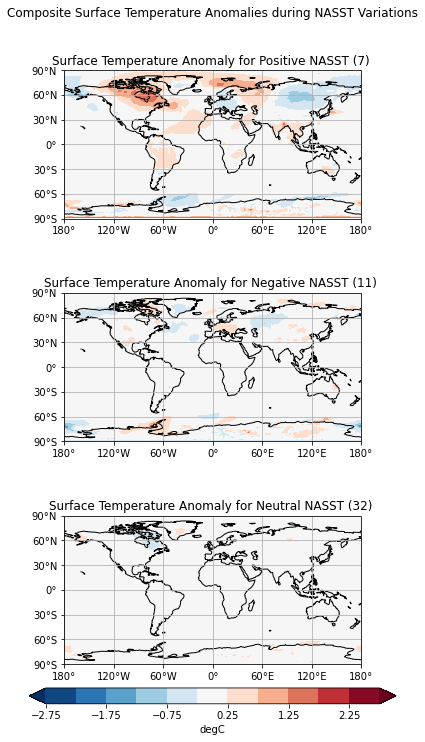

In [18]:
labels = ['Positive NASST', 'Negative NASST', 'Neutral NASST'];
clevs = np.arange( -2.75, 3.25, 0.5 );

## Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots( nrows = 3, ncols = 1,
                       subplot_kw = {'projection': ccrs.PlateCarree() },
                       figsize = (8.5, 11) );
## axs is a 2 dimensional array of 'GeoAxes'.
##We will flatten this into a 1D array
axs = axs.flatten();

##Loop over each of the conditions and plot
for i, nasst in enumerate( comp_ts ):
    ##Select the comp
    data = comp_ts[i]['ts'];
    ##Add the cyclic point
    data,lons = add_cyclic_point( data, coord = comp_ts[i]['lon'] );
    ##Create the contour plot
    cs = axs[i].contourf( lons, comp_ts[i]['lat'], data, clevs,
                        transform = ccrs.PlateCarree(),
                        cmap = 'RdBu_r', extend = 'both' );
    ##Longitude labels 
    axs[i].set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
    lon_formatter = cticker.LongitudeFormatter();
    axs[i].xaxis.set_major_formatter( lon_formatter );
    ##Latitude labels
    axs[i].set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
    lat_formatter = cticker.LatitudeFormatter();
    axs[i].yaxis.set_major_formatter( lat_formatter );
    ##Title each subplot with the name of the composite
    axs[i].set_title( 'Surface Temperature Anomaly for ' + labels[i] + ' (' + str(counts[i]) + ') ' );
    ##Draw the coastlines for each subplot
    axs[i].coastlines();
    axs[i].gridlines();
    
    
##Adjust the location of the subplots to make room for colorbar
fig.subplots_adjust( bottom = 0.15, top = 0.9, left = 0.05, right = 0.95,
                   wspace = 0.1, hspace = 0.5 );
##Add a colorbar axis
cbar_ax = fig.add_axes( [0.2, 0.1, 0.6, 0.02] );
cbar = fig.colorbar( cs, cax = cbar_ax, orientation = 'horizontal', label = 'degC' );

plt.suptitle( 'Composite Surface Temperature Anomalies during NASST Variations')

In [19]:
diff_ts = [pos_ts - neutral_ts, neg_ts-neutral_ts];
diff_ts

[<xarray.Dataset>
 Dimensions:   (bnds: 2, lat: 90, lon: 144)
 Coordinates:
   * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
 Dimensions without coordinates: bnds
 Data variables:
     lat_bnds  (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
     lon_bnds  (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
     ts        (lat, lon) float32 dask.array<chunksize=(90, 144), meta=np.ndarray>,
 <xarray.Dataset>
 Dimensions:   (bnds: 2, lat: 90, lon: 144)
 Coordinates:
   * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
 Dimensions without coordinates: bnds
 Data variables:
     lat_bnds  (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
     lon_bnds  (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
     ts        (

In [20]:
ptest = 0.05; 

a = ts_anoms.sel( year = pos_nasst.dropna( dim = 'year' )['year'] );
b = ts_anoms.sel( year = neutral.dropna( dim = 'year' )['year'] );
c = ts_anoms.sel( year = neg_nasst.dropna( dim = 'year' )['year'] );

pos_tstat,pos_pval = ttest_ind( a['ts'], b['ts'], equal_var = False );
neg_tstat,neg_pval = ttest_ind( c['ts'], b['ts'], equal_var = False );


In [21]:
pos_mask_diff = pos_ts['ts'].where( pos_pval < ptest );
neg_mask_diff = neg_ts['ts'].where( neg_pval < ptest );

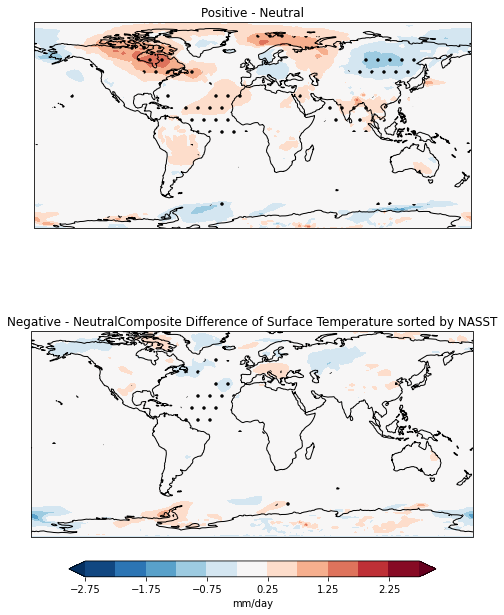

In [22]:
labels = ['Positive - Neutral', 'Negative - Neutral'];
clevs = np.arange( -2.75, 3.25, 0.5 );

fig, axs = plt.subplots( nrows = 2, ncols = 1,
                       subplot_kw = {'projection':ccrs.PlateCarree()},
                       figsize = (8.5,11) );
#axs = axs.flatten();

#for i,enso in enumerate( diff_precip ):
data = pos_ts['ts']

data,lons = add_cyclic_point( data, coord = ts_anoms['lon'] );
mask_data,lons = add_cyclic_point( pos_mask_diff, coord=ts_anoms['lon'] );

cs = axs[0].contourf( lons, pos_ts['lat'], data, clevs,
                        transform = ccrs.PlateCarree(),
                        cmap = 'RdBu_r', extend = 'both' );
axs[0].contourf( lons, ts_anoms['lat'], mask_data,
            [0,1], transform = ccrs.PlateCarree(), colors = 'None',
            hatches = ['.'], extend = 'both', alpha = 0 );
axs[0].set_title( labels[0] );
axs[0].coastlines();


data = neg_ts['ts']

data,lons = add_cyclic_point( data, coord = ts_anoms['lon'] );
mask_data,lons = add_cyclic_point( neg_mask_diff, coord=ts_anoms['lon'] );

cs = axs[1].contourf( lons, neg_ts['lat'], data, clevs,
                        transform = ccrs.PlateCarree(),
                        cmap = 'RdBu_r', extend = 'both' );
axs[1].contourf( lons, ts_anoms['lat'], mask_data,
            [0,1], transform = ccrs.PlateCarree(), colors = 'None',
            hatches = ['.'], extend = 'both', alpha = 0 );
axs[1].set_title( labels[1] + 'Composite Difference of Surface Temperature sorted by NASST' );
axs[1].coastlines();

    
fig.subplots_adjust( bottom = 0.25, top = 0.9, left = 0.05, right = 0.95,
                   wspace = 0.1, hspace = 0.5 );
cbar_ax = fig.add_axes( [0.2, 0.2, 0.6, 0.02] );
cbar = fig.colorbar( cs, cax = cbar_ax, orientation = 'horizontal', label = 'mm/day' );

Text(0.5, 1.0, 'Scatter Plot of Labrador Sea Surface Temperature')

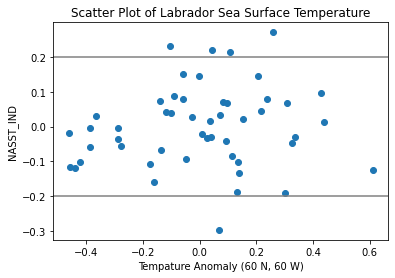

In [23]:
##Select out the point for the high composite value
pt_ts = ts_anoms.sel( lat = 60, lon = 360-60, method = 'nearest' );
plt.scatter( pt_ts['ts'], nasst_ind );
plt.xlabel( 'Tempature Anomaly (60 N, 60 W)' );
plt.ylabel( 'NASST_IND' );

plt.axhline( 0.2, color = 'gray' );
plt.axhline( -0.2, color = 'gray' );
plt.title( 'Scatter Plot of Labrador Sea Surface Temperature')

In [24]:
##Create a climatology to find the precipitation anomalies
pr_climo = pr_ds.mean( dim = 'year' );
pr_anoms = pr_ds - pr_climo;
pr_anoms

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 90, lon: 144, year: 50)
Coordinates:
  * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * year      (year) int64 2510 2511 2512 2513 2514 ... 2555 2556 2557 2558 2559
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 dask.array<chunksize=(1, 90, 2), meta=np.ndarray>
    lon_bnds  (year, lon, bnds) float64 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    pr        (year, lat, lon) float32 dask.array<chunksize=(1, 90, 144), meta=np.ndarray>

In [25]:
pos_pr = pr_anoms.sel( year = pos_nasst.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );
neg_pr = pr_anoms.sel( year = neg_nasst.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );
neutral_pr = pr_anoms.sel( year = neutral.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );

comp_pr = [pos_pr, neg_pr, neutral_pr];
print( comp_pr );
                             

[<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 90, lon: 144)
Coordinates:
  * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    pr        (lat, lon) float32 dask.array<chunksize=(90, 144), meta=np.ndarray>, <xarray.Dataset>
Dimensions:   (bnds: 2, lat: 90, lon: 144)
Coordinates:
  * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    pr        (lat, lon) float32 d

Text(0.5, 0.98, 'Composite Precipitation Anomalies during Variations in NASST')

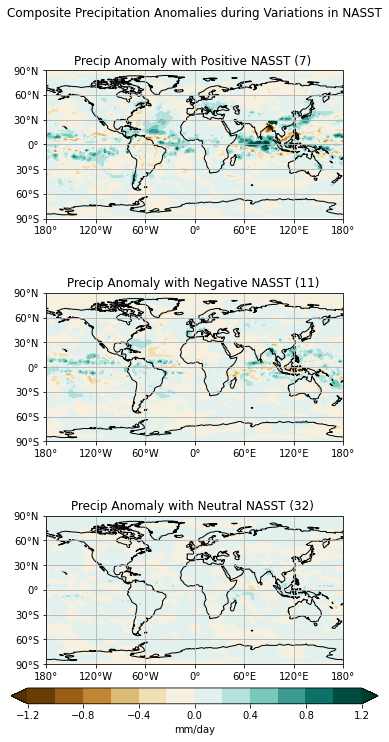

In [26]:
labels = ['Positive NASST', 'Negative NASST', 'Neutral NASST'];
clevs = np.arange( -1.2, 1.4, 0.2 );

## Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots( nrows = 3, ncols = 1,
                       subplot_kw = {'projection': ccrs.PlateCarree() },
                       figsize = (8.5, 11) );
## axs is a 2 dimensional array of 'GeoAxes'.
##We will flatten this into a 1D array
axs = axs.flatten();

##Loop over each of the conditions and plot
for i, enso in enumerate( comp_pr ):
    ##Select the comp
    data = comp_pr[i]['pr'];
    ##Add the cyclic point
    data,lons = add_cyclic_point( data, coord = comp_pr[i]['lon'] );
    ##Create the contour plot
    cs = axs[i].contourf( lons, comp_pr[i]['lat'], data, clevs,
                        transform = ccrs.PlateCarree(),
                        cmap = 'BrBG', extend = 'both' );
    ##Longitude labels 
    axs[i].set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
    lon_formatter = cticker.LongitudeFormatter();
    axs[i].xaxis.set_major_formatter( lon_formatter );
    ##Latitude labels
    axs[i].set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
    lat_formatter = cticker.LatitudeFormatter();
    axs[i].yaxis.set_major_formatter( lat_formatter );
    ##Title each subplot with the name of the composite
    axs[i].set_title( 'Precip Anomaly with ' + labels[i] + ' (' + str(counts[i]) + ') ' );
    ##Draw the coastlines for each subplot
    axs[i].coastlines();
    axs[i].gridlines();
    
    
##Adjust the location of the subplots to make room for colorbar
fig.subplots_adjust( bottom = 0.15, top = 0.9, left = 0.05, right = 0.95,
                   wspace = 0.1, hspace = 0.5 );
##Add a colorbar axis
cbar_ax = fig.add_axes( [0.2, 0.1, 0.6, 0.02] );
cbar = fig.colorbar( cs, cax = cbar_ax, orientation = 'horizontal', label = 'mm/day' );

plt.suptitle( 'Composite Precipitation Anomalies during Variations in NASST')

## Correlation of the Calculated AMV Index with Surface Variables

In [27]:
r_map = xr.corr( nasst_ind, ts_anoms['ts'], dim = 'year' );
r_map

<xarray.DataArray (lat: 90, lon: 144)>
dask.array<truediv, shape=(90, 144), dtype=float64, chunksize=(90, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8

Text(0.5, 1.0, 'Correlation of Surface Temperature and NASST Index')

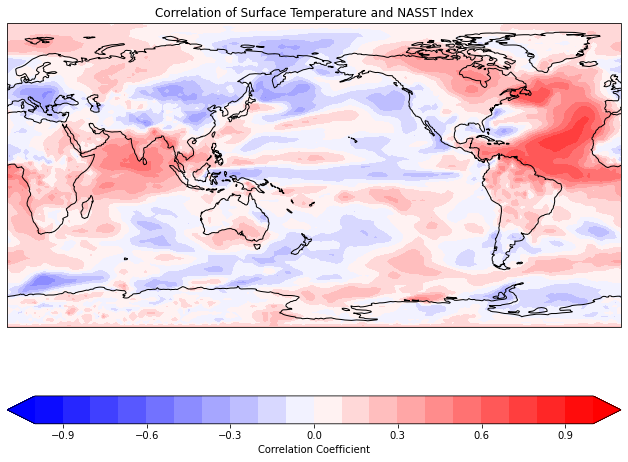

In [29]:
clevs = np.arange( -1, 1.1, 0.1 );
fig = plt.figure( figsize = (11,8.5) );

ax = plt.axes( projection=ccrs.PlateCarree( central_longitude = 180 ) );

data,lon = add_cyclic_point( r_map, coord = ts_anoms['lon'] );
#mask_data,lon = add_cyclic_point( mask_sig, coord = ts_anoms['lon'] );

cs = ax.contourf( lon, ts_anoms['lat'], data, clevs,
                transform = ccrs.PlateCarree(),
                cmap = 'bwr', extend = 'both' );
#ax.contourf( lon, ts_anoms['lat'], mask_data, [0,1],
           #transform = ccrs.PlateCarree(), colors = 'None',
           #hatches = ['.'], extend = 'both', alpha = 0 );

ax.coastlines()

cbar = plt.colorbar( cs, orientation = 'horizontal', label = 'Correlation Coefficient' );
plt.title( 'Correlation of Surface Temperature and NASST Index')

In [30]:
nx = len( ts_anoms['lon'] );
ny = len( ts_anoms['lat'] );

r_array = np.zeros( (ny,nx) );
p_array = np.zeros( (ny,nx) );
#p_array = np.copy( r_array );

for i in range( nx ):
    #for j in range( ny ):
    j = 1;
    r,p = pearsonr( nasst_ind, ts_anoms['ts'][:,j,i] );
        
    r_array[j,i] = r;
    p_array[j,i] = p;

In [31]:
mask_sig = np.where( p_array < 0.05, r_array, np.nan );
mask_sig

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

AttributeError: 'Figure' object has no attribute 'title'

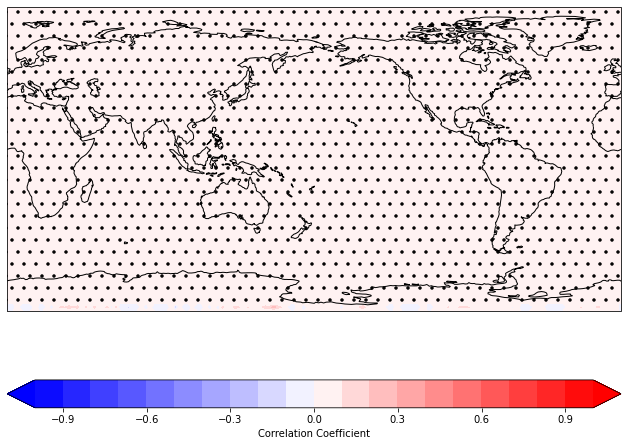

In [32]:
clevs = np.arange( -1, 1.1, 0.1 );
fig = plt.figure( figsize = (11,8.5) );

ax = plt.axes( projection=ccrs.PlateCarree( central_longitude = 180 ) );

data,lon = add_cyclic_point( r_array, coord = ts_anoms['lon'] );
mask_data,lon = add_cyclic_point( mask_sig, coord = ts_anoms['lon'] );

cs = ax.contourf( lon, ts_anoms['lat'], data, clevs,
                transform = ccrs.PlateCarree(),
                cmap = 'bwr', extend = 'both' );
ax.contourf( lon, ts_anoms['lat'], mask_data, [0,1],
           transform = ccrs.PlateCarree(), colors = 'None',
           hatches = ['.'], extend = 'both', alpha = 0 );

ax.coastlines()

cbar = plt.colorbar( cs, orientation = 'horizontal', label = 'Correlation Coefficient' );
fig.title( 'Incorrect Correlation Coefficients for Surface Temperature against NASST')

## Linear Regression Analysis

In [ ]:

nx = len( ts_anoms['lon'] );
ny = len( ts_anoms['lat'] );

#Create empty arrays to store the linregress output
m_array = np.zeros( ( ny, nx ) );
r_array = np.zeros( ( ny, nx ) );
p_array = np.zeros( ( ny, nx ) );


for i in range( nx ):
    for j in range( ny ):
        
        x = nasst_ind;
        y = ts_anoms['ts'][:,j,i];
        m_array[j,i],b,r_array[j,i],p_array[j,i],e = lr( x, y)

In [ ]:
mask_sig = np.where( p_array < 0.05, 1, np.nan );
mask_sig

In [ ]:
clevs = np.arange( -2.25, 2.75, 0.5 );
fig = plt.figure( figsize = (11,8.5) );
ax = plt.axes( projection = ccrs.PlateCarree( central_longitude = 180 ) );

data, lons = add_cyclic_point( m_array, coord = ts_anoms['lon'] );
mask_data, lon = add_cyclic_point( mask_sig, coord = ts_anoms['lon'] );

cs = ax.contourf( ts_anoms['lon'], ts_anoms['lat'], m_array, clevs,
                transform = ccrs.PlateCarree(),
                cmap = 'RdBu_r', extend = 'both' );
#Could give contour levels (especially if the mask has levels), with the symbols assigned by hatches corresponding to each contour level
ax.contourf( lons, ts_anoms['lat'], mask_data, 
           transform = ccrs.PlateCarree(), colors = 'None',
            hatches = ['.'], extend = 'both', alpha = 0 )

ax.coastlines();

cbar = plt.colorbar( cs, orientation = 'horizontal', label = 'Regression Coefficient' );
plt.title( 'Precipitation Regression Coefficient w/ NINO34 hatched with Significance > 95%' );